# Processing Volume and Mesh Data
The goals for this exercise are:
1. Reading volume data from a file
2. Visualize the data and modify the rendering parameters
3. Learn how to extract a mesh
4. Learn how to separate the mesh (connected component analysis)
5. Perform Mesh smoothing
6. Analyze the smoothed results

In [2]:
# basic importas needed for this exercise
import vtk
import pyvista as pv
from pyvistaqt import BackgroundPlotter

import numpy as np
import matplotlib.pyplot as plt

## 1. Reading Volume Data

Reading Volume is performed by one of the many `Reader` classes in VTK, for example `vtkDICOMReader`, `vtkNIFIImageReader`, `vtkMetaImageReader`.

![imagereaders](data/figures/ImageReaders.png)
 
All of them have a `SetFileName` method to set a filename, and you can read the output as you want

In [3]:
fileName = 'data/foot128.nii.gz'

Our file is a compressed NIFTI file, so we will use a `vtkNIFTIImageReader` to read it in!

In [4]:
reader = vtk.vtkNIFTIImageReader()
reader.SetFileName(fileName)

Don't forget to call update, otherwise the components are only connected. 
Update has to be called specifically, to not automatically update everytime a single thing changes

In [5]:
reader.Update()

In [6]:
reader.GetOutput()

<vtkmodules.vtkCommonDataModel.vtkImageData(0x7fd3ad83c880) at 0x108735fc0>

In [7]:
image = pv.wrap(reader.GetOutput())

In [8]:
image

ImageData (0x1244e4a00)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     1

## 2. Visualize Data

Allright, so let's look at this!

In [8]:
wnd = BackgroundPlotter()

In [9]:
wnd.add_volume(image)

<Volume(0x7fd9ba0d4c00) at 0x120f3ee60>

In [10]:
wnd.clear()

In [11]:
wnd.add_volume(image, clim=(35, 255), cmap='bone') # visualization as bone

<Volume(0x7fd9b99b5000) at 0x120f3ec20>

Create a customized opacity function - this is not really required but I left it here as an example.

In [12]:
opacity_tf=np.linspace(0.0, 1.0, 256)
opacity_tf = 255.0*(opacity_tf ** 2.5)# + 16

In [13]:
opacity_tf[0:5] = 0

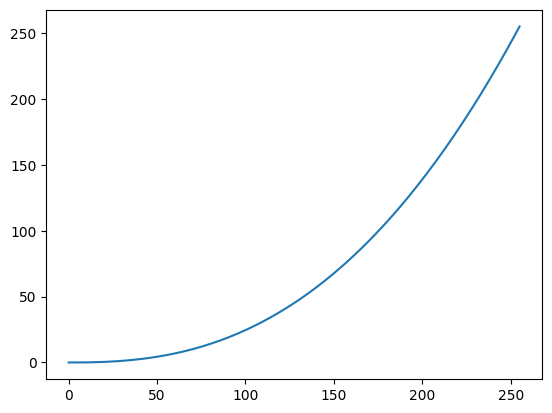

In [14]:
plt.plot(opacity_tf)

In [15]:
wnd.clear()
vol_actor = wnd.add_volume(image, opacity=opacity_tf)

Let's try change the transfer function! Look at https://kitware.github.io/vtk-examples/site/Python/VolumeRendering/SimpleRayCast/ to see an example!

In [16]:
# Create transfer mapping scalar value to color.
colorTransferFunction = vtk.vtkColorTransferFunction()
colorTransferFunction.AddRGBPoint(0.0, 1.0, 0.0, 0.0)
colorTransferFunction.AddRGBPoint(64.0, 0.2, 0.0, 0.0)
colorTransferFunction.AddRGBPoint(128.0, 0.0, 0.0, 1.0) # 20
colorTransferFunction.AddRGBPoint(192.0, 0.0, 0.5, 0.0) # 60
colorTransferFunction.AddRGBPoint(255.0, 0.0, 0.2, 0.0)

4

In [17]:
# Create transfer mapping scalar value to opacity.
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(30, 0.0)
opacityTransferFunction.AddPoint(255, 0.2)

1

In [18]:
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorTransferFunction)
volumeProperty.SetScalarOpacity(opacityTransferFunction)
volumeProperty.ShadeOff()
volumeProperty.SetInterpolationTypeToLinear()

In [19]:
vol_actor.SetProperty(volumeProperty)

#### Just out of curiosity, let's try to plot the used color map
> Again, completely unnecessary but left in here for reference

In [20]:
lin = np.linspace(0, 255, 255)

In [21]:
ramp = []
for v in lin:
    ramp.append(colorTransferFunction.GetColor(v))

In [22]:
ramp = np.array([ramp])

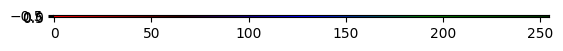

In [23]:
plt.imshow(ramp)

Ok this is just an image consisting of a single line - repeat it to increase visibility

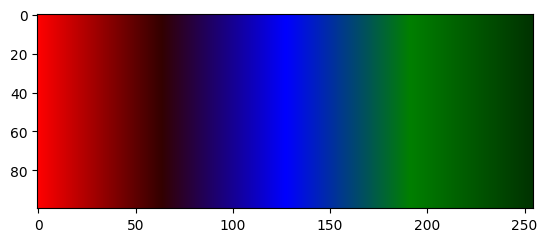

In [24]:
plt.imshow(np.repeat(ramp, 100, axis=0))

In [24]:
# ~~~ I wonder what's going to happen next.. maybe segmentation?! ~~~

## 3. Mesh Segmentation
Segmentation can be performed using the marching cubes algorithm introduced in the lecture.
VTK implements this algorithm in the [`vtkMarchingCubes`](https://vtk.org/doc/nightly/html/classvtkMarchingCubes.html#afd541e392d09571aac3a58ac2abee287) class.

In [44]:
wnd = BackgroundPlotter()

In [9]:
boneExtractor = vtk.vtkMarchingCubes()
boneExtractor.SetInputConnection(reader.GetOutputPort())
boneExtractor.SetValue(0, 70)
boneExtractor.Update()

In [46]:
pv.wrap(boneExtractor.GetOutput())

PolyData (0x121031d80)
  N Cells:    137183
  N Points:   69161
  N Strips:   0
  X Bounds:   1.858e+01, 1.090e+02
  Y Bounds:   0.000e+00, 1.183e+02
  Z Bounds:   3.167e+00, 1.195e+02
  N Arrays:   2

Vtk internally needs to convert the generic poly data to something that can be rendered - namely a set of triangles.

The [`vtkStripper`](https://vtk.org/doc/nightly/html/classvtkStripper.html) class creates triangle strips or poly line strips from a generic `vtkPolyData` object for performance reasons. A [`vtkPolyDataMapper`](https://vtk.org/doc/nightly/html/classvtkPolyDataMapper.html) is needed to map the poly data to the GPU. From the output of the mapper, we can then create a `vtkActor` object that can be attached to the renderer.

In [10]:
boneStripper = vtk.vtkStripper()
boneStripper.SetInputConnection(boneExtractor.GetOutputPort())

boneMapper = vtk.vtkPolyDataMapper()
boneMapper.SetInputConnection(boneStripper.GetOutputPort())
boneMapper.ScalarVisibilityOff()

In [11]:
bone = vtk.vtkActor()
bone.SetMapper(boneMapper)
colors = vtk.vtkNamedColors()
bone.GetProperty().SetDiffuseColor(colors.GetColor3d("Ivory"))

In [49]:
wnd.add_actor(bone, reset_camera=True)

(<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x7fd9b8cfbcc0) at 0x13d343e80>,
 <vtkmodules.vtkRenderingOpenGL2.vtkOpenGLProperty(0x7fd9b8cfc8e0) at 0x120f3df00>)

In [12]:
boneExtractor.SetValue(0, 12)

In [13]:
boneExtractor.SetValue(0, 70)

We can also add a slice to the rendering very easily

In [53]:
bwLut = vtk.vtkLookupTable()
bwLut.SetTableRange(0, 255)
bwLut.SetSaturationRange(0, 0)
bwLut.SetHueRange(0, 0)
bwLut.SetValueRange(0, 1)
bwLut.Build()  # effective built
    
sagittalColors = vtk.vtkImageMapToColors()
sagittalColors.SetInputConnection(reader.GetOutputPort())
sagittalColors.SetLookupTable(bwLut)
sagittalColors.Update()

In [54]:
sagittal = vtk.vtkImageActor()
sagittal.GetMapper().SetInputConnection(sagittalColors.GetOutputPort())

In [55]:
sag_slice = 64
sagittal.SetDisplayExtent(sag_slice, sag_slice,0,127,0,127)

In [56]:
wnd.add_actor(sagittal)

(<vtkmodules.vtkRenderingCore.vtkImageActor(0x7fd9c25be050) at 0x13aa39f60>,
 <vtkmodules.vtkRenderingCore.vtkImageProperty(0x600002a6c820) at 0x105c5e980>)

In [57]:
sagittal.SetDisplayExtent(0, 200, 0, 127, 0, 127)

In [58]:
bwLut.SetTableRange(0,100)

### Bonus points - use an `ipywidgets.IntSlider` and `observe` to update the threshold interactively!

In [59]:
import ipywidgets as widgets

In [60]:
def update_val(v):
    boneExtractor.SetValue(0, thresh_widget.value)

In [61]:
thresh_widget = widgets.IntText(value=7, description='Threshold: ', disabled=False, step=10)
thresh_widget.observe(update_val, 'value')
display(thresh_widget)

IntText(value=7, description='Threshold: ', step=10)

## Separate the mesh into connected components

Our goal is now to extract the connected components of the mesh.

See [ConnectivityFilter](https://vtk.org/doc/nightly/html/classvtkConnectivityFilter.html)

In [14]:
connectivityFilter = vtk.vtkConnectivityFilter()
connectivityFilter.SetInputConnection(boneExtractor.GetOutputPort())
connectivityFilter.SetExtractionModeToAllRegions()
connectivityFilter.ColorRegionsOn()
connectivityFilter.Update()

In [15]:
wnd = BackgroundPlotter()
wnd.add_mesh(connectivityFilter.GetOutput())

Actor (0x1244e5900)
  Center:                     (63.407050132751465, 59.16128921508789, 61.31862771511078)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.858E+01, 1.082E+02
  Y Bounds                    0.000E+00, 1.183E+02
  Z Bounds                    3.167E+00, 1.195E+02
  User matrix:                Set
  Has mapper:                 True

Property (0x1244e6500)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Ed

In [16]:
connectivityFilter.GetOutput()

<vtkmodules.vtkCommonDataModel.vtkPolyData(0x7fd3a4dc1b20) at 0x109302b60>

In [20]:
wnd = BackgroundPlotter()

connectivityFilter.SetExtractionModeToLargestRegion()

mapper = vtk.vtkDataSetMapper()
mapper.SetInputConnection(connectivityFilter.GetOutputPort())
mapper.Update()

actor = vtk.vtkActor()
actor.SetMapper(mapper)

wnd.add_actor(mapper)

(Actor (0x1244e4700)
   Center:                     (58.07738018035889, 55.59375, 23.696236968040466)
   Pickable:                   True
   Position:                   (0.0, 0.0, 0.0)
   Scale:                      (1.0, 1.0, 1.0)
   Visible:                    True
   X Bounds                    1.858E+01, 9.757E+01
   Y Bounds                    0.000E+00, 1.112E+02
   Z Bounds                    3.167E+00, 4.423E+01
   User matrix:                Set
   Has mapper:                 True
 
 Property (0x1244e5840)
   Ambient:                     0.0
   Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Anisotropy:                  0.0
   Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Culling:                     "none"
   Diffuse:                     1.0
   Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Edge color:                  Color(name='black', hex='#000000ff', opaci

## Mesh Smoothing

See [`vtkSmoothPolyDataFilter`](https://vtk.org/doc/nightly/html/classvtkSmoothPolyDataFilter.html)

In [21]:
smoothingFilter = vtk.vtkSmoothPolyDataFilter()

In [22]:
smoothingFilter.SetInputConnection(connectivityFilter.GetOutputPort())
smoothingFilter.SetRelaxationFactor(0.2)
smoothingFilter.Update()

In [23]:
wnd = BackgroundPlotter()
wnd.add_mesh(smoothingFilter.GetOutput(), reset_camera=False)

Actor (0x1244e76a0)
  Center:                     (58.66114044189453, 55.341957092285156, 23.65778338909149)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.975E+01, 9.757E+01
  Y Bounds                    0.000E+00, 1.107E+02
  Z Bounds                    3.512E+00, 4.380E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x1244e6ec0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Ed

Now let's quantify our smoothing error by measuring the distance to the original! This cam be done using a [`vtkDistancePolyDataFilter`](https://vtk.org/doc/nightly/html/classvtkDistancePolyDataFilter.html)

#### Curvature
Computed with [`vtkCurvatures`](https://lorensen.github.io/VTKExamples/site/Cxx/PolyData/Curvatures/)

In [24]:
wnd = BackgroundPlotter(shape=(2,1))

In [25]:
curvFilt = vtk.vtkCurvatures()
curvFilt.SetInputConnection(connectivityFilter.GetOutputPort())
curvFilt.Update()

clim and color map can be adjusted.

The color maps can be adopted from [matplotlib color maps](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

In [26]:
wnd.subplot(0, 0)
wnd.add_mesh(curvFilt.GetOutput(), scalars='Gauss_Curvature', clim=(-0.3, 0.3), cmap='Spectral')

Actor (0x124568b20)
  Center:                     (58.07738018035889, 55.59375, 23.696236968040466)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.858E+01, 9.757E+01
  Y Bounds                    0.000E+00, 1.112E+02
  Z Bounds                    3.167E+00, 4.423E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x124569000)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacit

In [27]:
wnd.subplot(1, 0)
curvFilt.SetInputConnection(smoothingFilter.GetOutputPort())
curvFilt.Update()
wnd.add_mesh(curvFilt.GetOutput(), scalars='Gauss_Curvature', clim=(-0.3, 0.3), cmap='Spectral')

Actor (0x124568a00)
  Center:                     (58.66114044189453, 55.341957092285156, 23.65778338909149)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.975E+01, 9.757E+01
  Y Bounds                    0.000E+00, 1.107E+02
  Z Bounds                    3.512E+00, 4.380E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x124568be0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Ed

#### Mesh Distance

In [28]:
distanceFilter = vtk.vtkDistancePolyDataFilter()
distanceFilter.SetInputConnection( 0, smoothingFilter.GetOutputPort() )
distanceFilter.SetInputConnection( 1, connectivityFilter.GetOutputPort() )
distanceFilter.Update();

Don't forget to use an appropriate [Colormap](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)!

In [29]:
distance_result = pv.wrap(distanceFilter.GetOutput())
distance_result.set_active_scalars('Distance')

wnd = BackgroundPlotter()
wnd.add_mesh(distance_result, cmap='Spectral', clim=(-1, 1))

Actor (0x124569300)
  Center:                     (58.66114044189453, 55.341957092285156, 23.65778338909149)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.975E+01, 9.757E+01
  Y Bounds                    0.000E+00, 1.107E+02
  Z Bounds                    3.512E+00, 4.380E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x1245697e0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Ed

In [31]:
distance_data = pv.wrap(distanceFilter.GetOutput())
distance_data

PolyData (0x12456bf40)
  N Cells:    50800
  N Points:   69107
  N Strips:   0
  X Bounds:   1.975e+01, 1.082e+02
  Y Bounds:   0.000e+00, 1.183e+02
  Z Bounds:   3.512e+00, 1.195e+02
  N Arrays:   6

### Further analysis of the distance data

In [32]:
distances = distance_data.get_array('Distance', preference='point')

In [33]:
from matplotlib import pyplot as plt

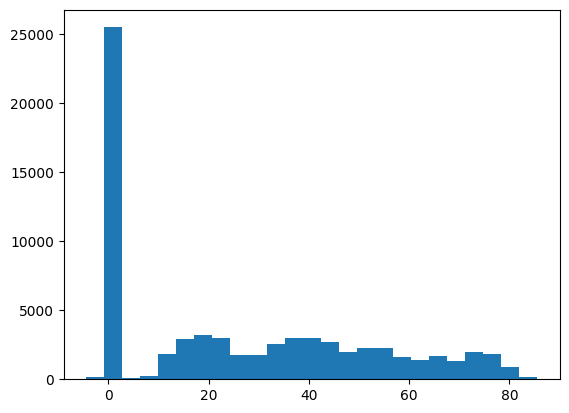

In [34]:
H = plt.hist(distances, bins=25)

### A better Smoothing filter: Taubin Smoothing (aka `WindowedSincPolyDataFilter`)

Laplacian smoothing has a problem with high number of iterations - it causes geometry to shrink as it converges to the centroid after a high number of iterations:

In [35]:
smoothingFilter.SetNumberOfIterations(1000)
smoothingFilter.SetConvergence(0.001)
smoothingFilter.SetBoundarySmoothing(False)
smoothingFilter.Update()

wnd = BackgroundPlotter(shape=(2,1))
wnd.subplot(0,0)
wnd.add_mesh(smoothingFilter.GetOutput(), color='Ivory')
wnd.subplot(1,0)
wnd.add_mesh(connectivityFilter.GetOutput(), color='Ivory')

Actor (0x124605c00)
  Center:                     (58.07738018035889, 55.59375, 23.696236968040466)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.858E+01, 9.757E+01
  Y Bounds                    0.000E+00, 1.112E+02
  Z Bounds                    3.167E+00, 4.423E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x1688da380)
  Ambient:                     0.0
  Ambient color:               Color(name='ivory', hex='#fffff0ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='ivory', hex='#fffff0ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='ivory', hex='#fffff0ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:          

Taubin smoothing implements a more optimal filter: 

VTK implements it in [vtkWindowedSincPolyDataFilter](https://vtk.org/doc/nightly/html/classvtkWindowedSincPolyDataFilter.html).

The most important parameters are `NumberOfIterations` and `PassBand` ~= 0.1

In [36]:
windowedSincFilter = vtk.vtkWindowedSincPolyDataFilter()

In [37]:
windowedSincFilter.SetInputConnection(connectivityFilter.GetOutputPort())
windowedSincFilter.SetNumberOfIterations(1000)
windowedSincFilter.SetPassBand(0.1)
windowedSincFilter.Update()

In [38]:
wnd = BackgroundPlotter(shape=(2,1))
wnd.subplot(0,0)
wnd.add_mesh(smoothingFilter.GetOutput(), color='Ivory')
wnd.subplot(1,0)
wnd.add_mesh(windowedSincFilter.GetOutput(), color='Ivory')

Actor (0x108458520)
  Center:                     (58.713157653808594, 55.392311096191406, 23.756874680519104)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.984E+01, 9.758E+01
  Y Bounds                    0.000E+00, 1.108E+02
  Z Bounds                    3.277E+00, 4.424E+01
  User matrix:                Set
  Has mapper:                 True

Property (0x124568a60)
  Ambient:                     0.0
  Ambient color:               Color(name='ivory', hex='#fffff0ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='ivory', hex='#fffff0ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='ivory', hex='#fffff0ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity

Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.poll_control_queue() running at /Users/michaelsommersperger/anaconda3/envs/CAMP2_Visualization_Exercise/lib/python3.11/site-packages/ipykernel/kernelbase.py:296> wait_for=<Future finished result=<Future at 0x...state=pending>> cb=[_chain_future.<locals>._call_set_state() at /Users/michaelsommersperger/anaconda3/envs/CAMP2_Visualization_Exercise/lib/python3.11/asyncio/futures.py:394]>
